In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score

# Tải dữ liệu gốc
df = pd.read_csv('weather_data_danang.csv')

# --- 1. FEATURE ENGINEERING SIÊU TINH GỌN (ULTRAL-LEAN) ---
# Chiến lược: "Chất lượng hơn Số lượng". Chỉ giữ lại những nhân tố quyết định nhất.

df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

# A. Đặc trưng chu kỳ (Cyclical) - Giữ nguyên vì rất quan trọng và ít chiều
df['hour_sin'] = np.sin(2 * np.pi * df['time'].dt.hour / 24) 
df['hour_cos'] = np.cos(2 * np.pi * df['time'].dt.hour / 24) 
df['month_sin'] = np.sin(2 * np.pi * df['time'].dt.month / 12) 
df['month_cos'] = np.cos(2 * np.pi * df['time'].dt.month / 12) 

# B. Lags & Rolling - CẮT GIẢM MẠNH TAY
# Chỉ lấy Lag cho 3 biến quan trọng nhất liên quan đến mưa: Nhiệt, Ẩm, Áp suất
critical_cols = ['temperature_2m', 'relative_humidity_2m', 'surface_pressure']
cols_to_lag = [c for c in critical_cols if c in df.columns]

for col in cols_to_lag:
    # Chỉ giữ duy nhất Lag 1 (1 giờ trước) -> Tín hiệu mạnh nhất ngay tức thì
    df[f'{col}_lag1'] = df[col].shift(1)
    
    # BỎ HOÀN TOÀN Rolling Mean/Std để giảm số chiều
    # Thay vào đó, dùng Lag 3 nhưng chỉ cho Áp suất (vì áp suất giảm trước khi bão về)
    if col == 'surface_pressure':
        df[f'{col}_lag3'] = df[col].shift(3) 

# C. Xu hướng (Trends) - Chỉ giữ xu hướng Áp suất
df['pressure_diff_3h'] = df['surface_pressure'].diff(3)
# Bỏ temp_diff_3h

# D. Feature kết hợp (Interaction)
df['humidex_proxy'] = df['temperature_2m'] * df['relative_humidity_2m']

# E. Phân nhóm Weather Group
def group_weather(code):
    if code <= 3: return 'Cloudy' 
    if code <= 55: return 'Drizzle' 
    if code <= 65: return 'Rain'
    return 'Storm/Other' 
df['weather_group'] = df['weather_code'].apply(group_weather)

# F. Làm sạch
df.dropna(inplace=True)
drop_cols = ['time', 'weather_code', 'rain', 'showers', 'snow_depth', 'wind_speed_10m', 'cloud_cover'] 
# Loại bỏ thêm wind_speed và cloud_cover gốc nếu muốn giảm thêm (tùy chọn, ở đây ta cứ drop các cột gây leak)
# Lưu ý: Giữ lại wind_speed_10m và cloud_cover làm feature gốc nếu thấy cần, 
# nhưng ở trên ta đã KHÔNG tạo lag cho chúng để tiết kiệm không gian.
df = df.drop(columns=['time', 'weather_code', 'rain', 'showers', 'snow_depth'], errors='ignore')

print(f"Total Features (Ultra Compact): {df.shape[1]-1}")
print(f"Features list: {list(df.columns)}")
df.head(3)

Total Features (Ultra Compact): 16
Features list: ['temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'surface_pressure', 'cloud_cover', 'wind_speed_10m', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'temperature_2m_lag1', 'relative_humidity_2m_lag1', 'surface_pressure_lag1', 'surface_pressure_lag3', 'pressure_diff_3h', 'humidex_proxy', 'weather_group']


,temperature_2m,relative_humidity_2m,dew_point_2m,surface_pressure,cloud_cover,wind_speed_10m,hour_sin,hour_cos,month_sin,month_cos,temperature_2m_lag1,relative_humidity_2m_lag1,surface_pressure_lag1,surface_pressure_lag3,pressure_diff_3h,humidex_proxy,weather_group
3,22.6,90,20.9,1013.6,100,2.4,0.707107,0.707107,0.5,0.866025,22.4,92.0,1014.0,1015.0,-1.4,2034.0,Drizzle
4,22.5,90,20.8,1013.4,98,3.4,0.866025,0.500000,0.5,0.866025,22.6,90.0,1013.6,1014.7,-1.3,2025.0,Drizzle
5,22.9,87,20.5,1013.9,99,3.3,0.965926,0.258819,0.5,0.866025,22.5,90.0,1013.4,1014.0,-0.1,1992.3,Drizzle


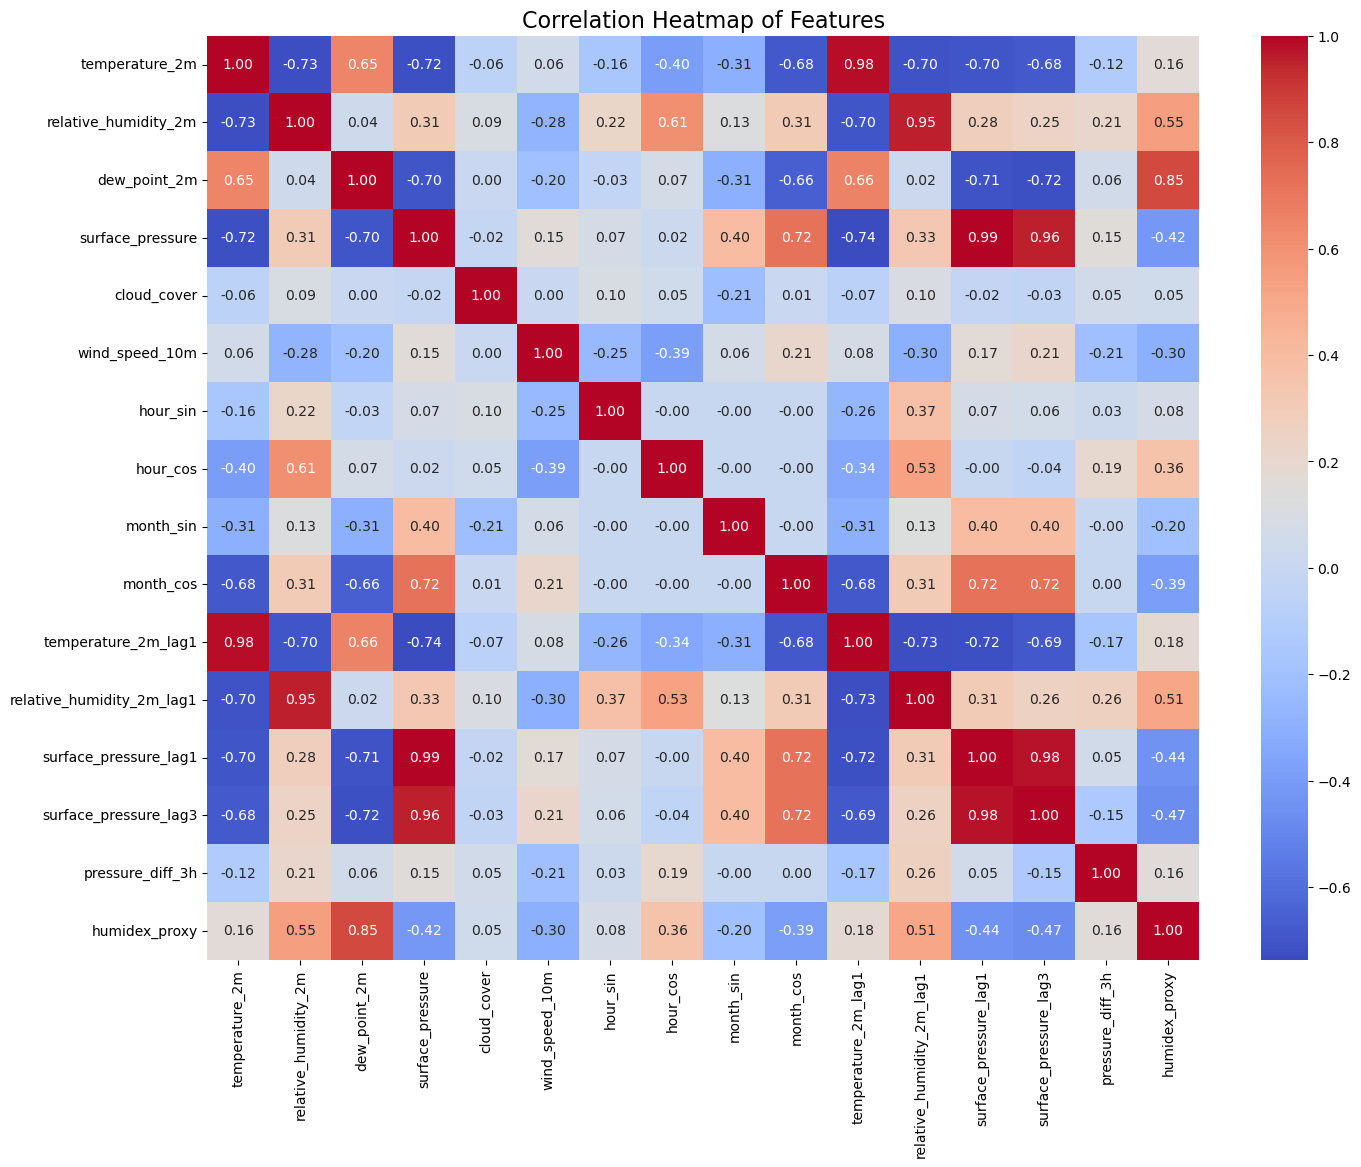

In [51]:
# vẽ sơ đồ heatmap 
from xarray import corr
plt.figure(figsize=(16, 12))
d = df.drop("weather_group", axis=1)
sns.heatmap(d.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Features', fontsize=16)
plt.show()

In [52]:
# Tách Features (X) và Target (y)
X = df.drop(columns=['weather_group'])
y = df['weather_group']

# Mã hóa nhãn từ chữ (Drizzle, Rain...) sang số (0, 1, 2...) 
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Các lớp thời tiết:")
for i, class_name in enumerate(le.classes_):
    print(f"{i}: {class_name}")

Các lớp thời tiết:
0: Cloudy
1: Drizzle
2: Rain


In [53]:
# Chia Train và tập tạm (Val + Test) 
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Chia tập tạm thành Validation và Test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape[0]} | Val: {X_val.shape[0]} | Test: {X_test.shape[0]}")

Train: 12295 | Val: 2635 | Test: 2635


In [54]:
from sklearn.feature_selection import SelectFromModel

# --- 2. SELECTIVE PREPROCESSING (TỐI ƯU CỰC ĐẠI) ---

print("Generating Polynomial Features...")
# CHỈNH SỬA QUAN TRỌNG: Chỉ tạo feature bậc 2, KHÔNG tạo interaction chồng chéo
# degree=2, interaction_only=True: Chỉ tạo a*b, không tạo a^2, b^2
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

print("Scaling Data (RobustScaler)...")
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_val_scaled = scaler.transform(X_val_poly)
X_test_scaled = scaler.transform(X_test_poly)

print("Feature Selection (Lasso Aggressive)...")
# GIẢM SỐ ĐẶC TRƯNG MẠNH HƠN NỮA
# Giảm C xuống 0.05 -> Phạt cực nặng các feature yếu
selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', C=0.05, random_state=42))

X_train_final = selector.fit_transform(X_train_scaled, y_train)
X_val_final = selector.transform(X_val_scaled)
X_test_final = selector.transform(X_test_scaled)

print(f"Features reduced drastically: {X_train_scaled.shape[1]} -> {X_train_final.shape[1]}")
print("Mô hình giờ đây rất nhẹ, chỉ giữ lại những 'tinh hoa' tuyệt đối.")

Generating Polynomial Features...
Scaling Data (RobustScaler)...
Feature Selection (Lasso Aggressive)...
Features reduced drastically: 136 -> 48
Mô hình giờ đây rất nhẹ, chỉ giữ lại những 'tinh hoa' tuyệt đối.


In [55]:
from sklearn.metrics import cohen_kappa_score, make_scorer, f1_score

# --- 3. TRAINING (TUNING ĐỂ TRÁNH OVERFITTING) ---
print("Training Softmax Regression (Regularized)...")

softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=3000, random_state=42)

# Điều chỉnh Param Grid:
# 1. Tập trung vào C nhỏ (0.01 - 0.5) để tăng Regularization (giảm Overfitting)
# 2. Tinh chỉnh class_weight
param_grid = {
    'C': [0.01, 0.05, 0.1, 0.2, 0.5, 1], # Bỏ các giá trị lớn (3, 10) gây overfitting
    'class_weight': [
        'balanced', 
        {0:1, 1:2, 2:5},    # Trọng số tập trung mạnh vào mưa
        {0:1, 1:1.5, 2:3}   # Trọng số vừa phải
    ]
}

scoring_metric = make_scorer(cohen_kappa_score) 

grid_search = GridSearchCV(
    softmax_reg, 
    param_grid, 
    cv=5, # Tăng CV lên 5 fold để đánh giá ổn định hơn (tránh bias do chia tập)
    scoring=scoring_metric,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_final, y_train)

best_model = grid_search.best_estimator_
print(f"Best Params: {grid_search.best_params_}")

# Kiểm tra nhanh trên Val
val_pred = best_model.predict(X_val_final)
print(f"Validation Kappa: {cohen_kappa_score(y_val, val_pred):.4f}")
print(f"Validation Macro F1: {f1_score(y_val, val_pred, average='macro'):.4f}")

Training Softmax Regression (Regularized)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\t\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Params: {'C': 0.5, 'class_weight': {0: 1, 1: 1.5, 2: 3}}
Validation Kappa: 0.4925
Validation Macro F1: 0.6479


In [56]:
# Dự đoán trên tập training để xem chi tiết
# LƯU Ý: Phải dùng X_train_final (đã qua Feature Selection) thay vì X_train_scaled
y_train_pred = best_model.predict(X_train_final) 
print("--- ĐÁNH GIÁ CHI TIẾT TRÊN TẬP TRAIN ---")
print(classification_report(y_train, y_train_pred, target_names=le.classes_))

# Dự đoán trên tập Validation để xem chi tiết
y_val_pred = best_model.predict(X_val_final)
print("--- ĐÁNH GIÁ CHI TIẾT TRÊN TẬP VALIDATION ---")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))

# Dự đoán trên tập Test (dữ liệu hoàn toàn mới)
y_test_pred = best_model.predict(X_test_final) 
print("--- ĐÁNH GIÁ CHI TIẾT TRÊN TẬP TEST ---")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))

print(f"Độ chính xác trên tập Train: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Độ chính xác trên tập Val: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Độ chính xác trên tập Test: {accuracy_score(y_test, y_test_pred):.4f}")

--- ĐÁNH GIÁ CHI TIẾT TRÊN TẬP TRAIN ---
              precision    recall  f1-score   support

      Cloudy       0.86      0.86      0.86      8168
     Drizzle       0.62      0.59      0.60      3389
        Rain       0.57      0.67      0.61       738

    accuracy                           0.77     12295
   macro avg       0.68      0.71      0.69     12295
weighted avg       0.77      0.77      0.77     12295

--- ĐÁNH GIÁ CHI TIẾT TRÊN TẬP VALIDATION ---
              precision    recall  f1-score   support

      Cloudy       0.85      0.86      0.85      1750
     Drizzle       0.60      0.56      0.58       726
        Rain       0.48      0.55      0.51       159

    accuracy                           0.76      2635
   macro avg       0.64      0.66      0.65      2635
weighted avg       0.76      0.76      0.76      2635

--- ĐÁNH GIÁ CHI TIẾT TRÊN TẬP TEST ---
              precision    recall  f1-score   support

      Cloudy       0.86      0.86      0.86      1751
  

--- ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH TOÀN DIỆN (TẬP TEST) ---
Accuracy:       0.7750
Precision:      0.7755
Recall:         0.7750
F1-Score:       0.7751
Cohen's Kappa:  0.5319
------------------------------


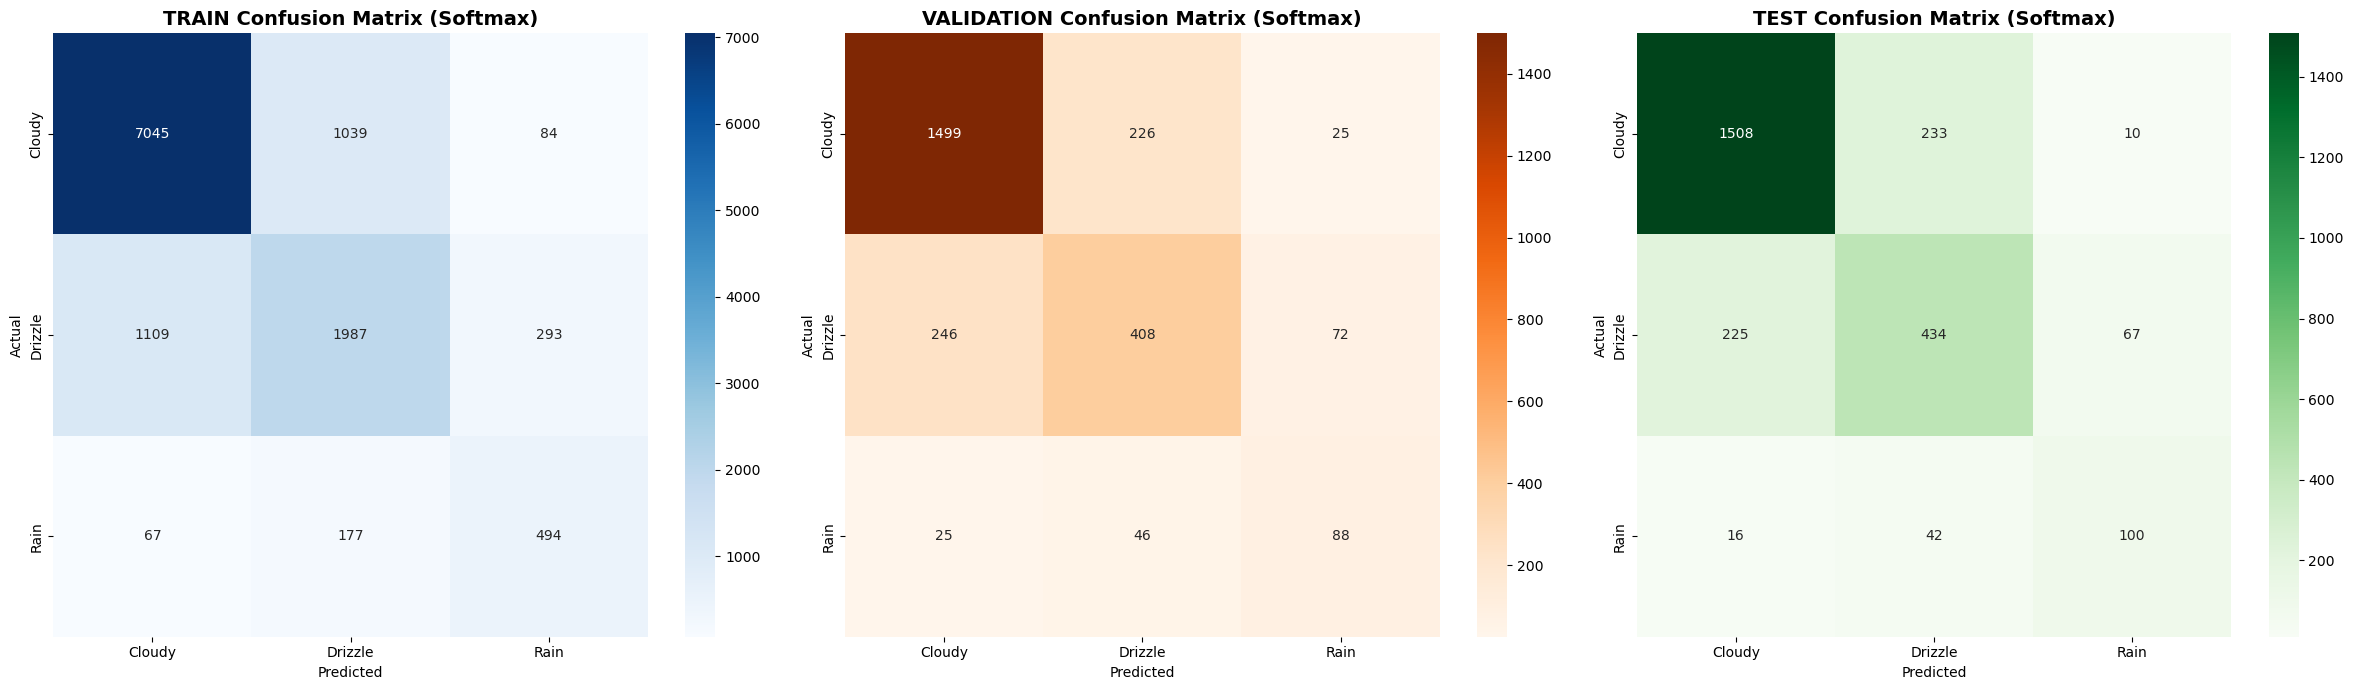

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

# "y_test" và "y_test_pred" đã được tạo ở các cell trước
print("--- ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH TOÀN DIỆN (TẬP TEST) ---")

# 1. Tính toán các chỉ số Numeric
acc = accuracy_score(y_test, y_test_pred)
# Weighted: Tính trung bình có trọng số (phù hợp dữ liệu mất cân bằng)
prec = precision_score(y_test, y_test_pred, average='weighted')
rec = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_test_pred)

print(f"Accuracy:       {acc:.4f}")
print(f"Precision:      {prec:.4f}")
print(f"Recall:         {rec:.4f}")
print(f"F1-Score:       {f1:.4f}")
print(f"Cohen's Kappa:  {kappa:.4f}")
print("-" * 30)

# VẼ 3 MA TRẬN NHẦM LẪN SIDE-BY-SIDE (TRAIN, VAL, TEST)
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# 1. Train Set
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[0].set_title('TRAIN Confusion Matrix (Softmax)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# 2. Validation Set
cm_val = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[1].set_title('VALIDATION Confusion Matrix (Softmax)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# 3. Test Set
cm_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axes[2],
            xticklabels=le.classes_, yticklabels=le.classes_)
axes[2].set_title('TEST Confusion Matrix (Softmax)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

--- VẼ BIỂU ĐỒ LOSS CURVE & ĐÁNH GIÁ (OVERFITTING/UNDERFITTING) ---
Using Best Params: {'C': 0.5, 'class_weight': {0: 1, 1: 1.5, 2: 3}}
Calculating loss over iterations...


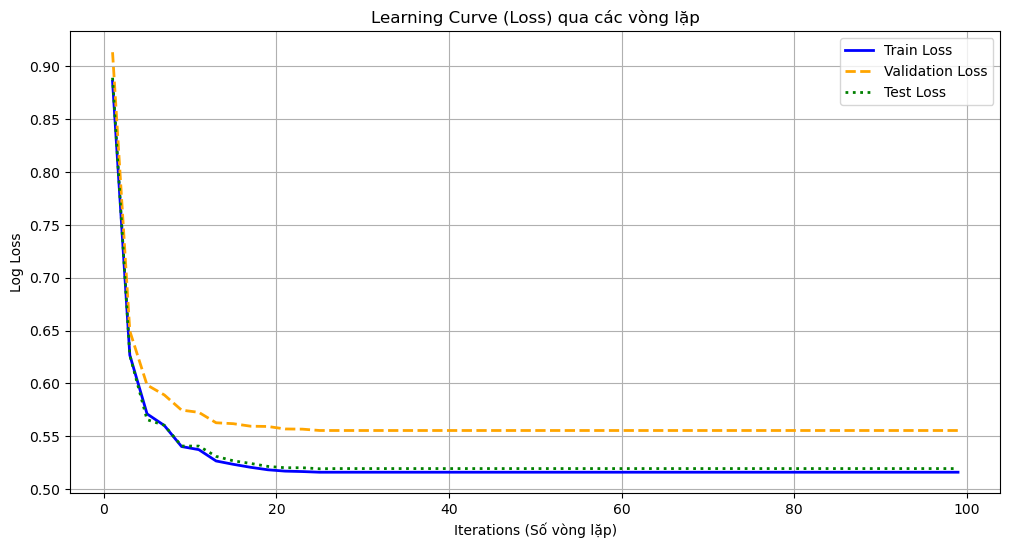


--- KẾT QUẢ CUỐI CÙNG ---
Final Train Loss: 0.5159
Final Val Loss:   0.5554
Gap (Val - Train): 0.0395

--- NHẬN XÉT (DIAGNOSIS) ---
✅ GOOD FIT: Train và Val Loss thấp và sát nhau.
-> Mô hình cân bằng tốt (Bias-Variance Tradeoff tối ưu).


In [58]:
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning

# Tắt cảnh báo hội tụ để output gọn gàng hơn trong vòng lặp
warnings.filterwarnings("ignore", category=ConvergenceWarning)

print("--- VẼ BIỂU ĐỒ LOSS CURVE & ĐÁNH GIÁ (OVERFITTING/UNDERFITTING) ---")

# 1. Lấy tham số tốt nhất từ GridSearch
best_params = grid_search.best_params_
print(f"Using Best Params: {best_params}")

# 2. Khởi tạo mô hình với warm_start=True để training từng bước
# warm_start=True giúp mô hình ghi nhớ coef_ từ bước trước đó
model_log = LogisticRegression(**best_params, solver='lbfgs', warm_start=True, random_state=42)

train_losses = []
val_losses = []
test_losses = []

# Range số vòng lặp (epochs/iterations)
# Lưu ý: lbfgs hội tụ khá nhanh, ta xét trong khoảng 1 -> 100 bước
iterations = range(1, 100, 2) 

print("Calculating loss over iterations...")
for i in iterations:
    model_log.set_params(max_iter=i)
    model_log.fit(X_train_final, y_train)
    
    # Tính Log Loss (Cross-Entropy Loss)
    # Log Loss càng thấp càng tốt
    tr_loss = log_loss(y_train, model_log.predict_proba(X_train_final))
    val_loss = log_loss(y_val, model_log.predict_proba(X_val_final))
    te_loss = log_loss(y_test, model_log.predict_proba(X_test_final))
    
    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    test_losses.append(te_loss)

# 3. Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(iterations, train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(iterations, val_losses, label='Validation Loss', color='orange', linestyle='--', linewidth=2)
plt.plot(iterations, test_losses, label='Test Loss', color='green', linestyle=':', linewidth=2)

plt.xlabel('Iterations (Số vòng lặp)')
plt.ylabel('Log Loss')
plt.title('Learning Curve (Loss) qua các vòng lặp')
plt.legend()
plt.grid(True)
plt.show()

# 4. Nhận xét tự động dựa trên kết quả cuối cùng
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
gap = final_val_loss - final_train_loss

print(f"\n--- KẾT QUẢ CUỐI CÙNG ---")
print(f"Final Train Loss: {final_train_loss:.4f}")
print(f"Final Val Loss:   {final_val_loss:.4f}")
print(f"Gap (Val - Train): {gap:.4f}")

print("\n--- NHẬN XÉT (DIAGNOSIS) ---")
if final_train_loss < 0.3 and gap > 0.1:
    print("⚠️ OVERFITTING CAO: Loss Train rất thấp nhưng Loss Val cao hơn đáng kể.")
    print("-> Khuyến nghị: Tăng Regularization (giảm C), giảm bớt features, hoặc thêm dữ liệu.")
elif final_train_loss > 0.6:
    print("⚠️ UNDERFITTING: Cả Train và Val Loss đều cao.")
    print("-> Khuyến nghị: Tăng độ phức tạp mô hình (thêm Poly degree, giảm Regularization - tăng C).")
elif gap > 0.05:
    print("⚠️ OVERFITTING NHẸ: Có sự chênh lệch giữa Train và Val, nhưng chấp nhận được.")
    print("-> Kết quả này khá tốt. Mô hình học được tổng quát.")
else:
    print("✅ GOOD FIT: Train và Val Loss thấp và sát nhau.")
    print("-> Mô hình cân bằng tốt (Bias-Variance Tradeoff tối ưu).")